In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15606933516162717219
xla_global_id: -1
]


In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [4]:
from random import random
from numpy import array
from numpy import cumsum
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from tensorflow import keras
from tensorflow.keras.callbacks import  EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers
from tensorflow.keras import backend as K
from keras.layers import Dense, Dropout, Conv2D, MaxPool1D, Flatten ,GRU
from numpy import zeros ,newaxis
from keras.layers import Input
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, Add, Flatten , GlobalAveragePooling1D ,Concatenate ,AveragePooling1D
from keras.layers import Input ,BatchNormalization
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, Flatten ,GRU
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import numpy
import pandas as pd
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from keras import layers
import keras

import matplotlib.pyplot as plt
import numpy as np


In [5]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset
dataframe = read_csv("WSN-DS.csv", header=None)

dataset = dataframe.values


#dataframe_test = read_csv("test_mosaic.csv", header=None)

#dataset_test = dataframe_test.values

In [6]:
X= dataset[:,0:18].astype(float)
Y= dataset[:,18]
#X_test= dataset_test[:,0:77].astype(float)
#Y_test= dataset_test[:,77]

In [7]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=33)



In [8]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.fit_transform(X_test)
X_train_new = SelectKBest(chi2, k=16).fit_transform(X_train_minmax,y_train)
X_test_new = SelectKBest(chi2, k=16).fit_transform(X_test_minmax,y_test)
X_train_new_2=X_train_new.reshape(X_train_new.shape[0],X_train_new.shape[1],1)

In [9]:
encoder = LabelEncoder()
encoder.fit( y_train)
encoded_Y = encoder.transform( y_train)
Train_dummy_y = to_categorical(encoded_Y)
encoder_test = LabelEncoder()
encoder_test.fit(y_test)
encoded_Y_test = encoder_test.transform(y_test)
test_dummy_y =to_categorical(encoded_Y_test)

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Dropout, LSTM, Bidirectional, Dense,
    Attention, GlobalAveragePooling1D, concatenate, LayerNormalization,
    MultiHeadAttention, Add, Flatten, Dense, Reshape)
from tensorflow.keras.regularizers import l2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder


# Define Multi-Scale Convolutional Block
def multi_scale_conv_block(inputs):
    conv1 = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(inputs)
    conv2 = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(inputs)
    #conv3 = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(inputs)


    concat = concatenate([conv1, conv2], axis=-1)
    bn = BatchNormalization()(concat)
    return Dropout(0.3)(bn)

# Attention Fusion Layer
def attention_fusion(inputs):
    # Spatial, Temporal, and Frequency Attention
    spatial_attention = Attention()([inputs, inputs])
    temporal_attention = Attention()([spatial_attention, spatial_attention])

    # Combining the attentions
    fused_attention = Add()([spatial_attention, temporal_attention])
    return fused_attention

def graph_conv_layer(inputs):
    conv = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
    bn = BatchNormalization()(conv)
    return Dropout(0.3)(bn)


# Bi-Directional LSTM with Attention
def bi_lstm_with_attention(inputs):
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    lstm_attention = Attention()([lstm_out, lstm_out])
    return lstm_attention



In [11]:
# Define input layer
inputs = Input(shape=(16, 1))

x = multi_scale_conv_block(inputs)

# Attention Fusion Layer
x = attention_fusion(x)

# Graph Convolutional Layer
x = graph_conv_layer(x)

# Bi-Directional LSTM with Time-Distorted Attention
x = bi_lstm_with_attention(x)

# Hierarchical Feature Aggregation and Dense Layers
x = GlobalAveragePooling1D()(x)
x = Dense(90, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.25)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.25)(x)

# Output Layer
outputs = Dense(5, activation='softmax')(x)  # Binary classification

from tensorflow.keras.optimizers import Adam



# Create model
model = Model(inputs=inputs, outputs=outputs)
# Compile the model
optimizer_Adam = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer_Adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, mode='auto', verbose=0)

checkpoint_path = 'model.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   mode='auto',
                                   verbose=1)

In [12]:

# Train the model
history = model.fit(
    X_train_new_2, Train_dummy_y,
    validation_data=(X_test_new, test_dummy_y),
    epochs=30,
    batch_size=128,
    callbacks=[early_stop, model_checkpoint]
)

Epoch 1/30
2341/2342 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8953 - loss: 0.5162
Epoch 1: val_loss improved from inf to 0.18301, saving model to model.h5


2342/2342 ━━━━━━━━━━━━━━━━━━━━ 179s 74ms/step - accuracy: 0.8953 - loss: 0.5160 - val_accuracy: 0.9479 - val_loss: 0.1830
Epoch 2/30
2341/2342 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9504 - loss: 0.1684
Epoch 2: val_loss improved from 0.18301 to 0.10918, saving model to model.h5


2342/2342 ━━━━━━━━━━━━━━━━━━━━ 203s 74ms/step - accuracy: 0.9504 - loss: 0.1684 - val_accuracy: 0.9662 - val_loss: 0.1092
Epoch 3/30
2342/2342 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9666 - loss: 0.1057
Epoch 3: val_loss improved from 0.10918 to 0.07986, saving model to model.h5


2342/2342 ━━━━━━━━━━━━━━━━━━━━ 169s 72ms/step - accuracy: 0.9666 - loss: 0.1057 - val_accuracy: 0.9743 - val_loss: 0.0799
Epoch 4/30
2341/2342 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9736 - loss: 0.0817
Epoch 4: val_loss improved from 0.07986 to 0.06984, saving model to model.h5


2342/2342 ━━━━━━━━━━━━━━━━━━━━ 193s 68ms/step - accuracy: 0.9736 - loss: 0.0817 - val_accuracy: 0.9766 - val_loss: 0.0698
Epoch 5/30
2341/2342 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9765 - loss: 0.0692
Epoch 5: val_loss improved from 0.06984 to 0.06090, saving model to model.h5


2342/2342 ━━━━━━━━━━━━━━━━━━━━ 213s 73ms/step - accuracy: 0.9765 - loss: 0.0692 - val_accuracy: 0.9768 - val_loss: 0.0609
Epoch 6/30
2341/2342 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9774 - loss: 0.0622
Epoch 6: val_loss improved from 0.06090 to 0.06022, saving model to model.h5


2342/2342 ━━━━━━━━━━━━━━━━━━━━ 189s 68ms/step - accuracy: 0.9774 - loss: 0.0622 - val_accuracy: 0.9772 - val_loss: 0.0602
Epoch 7/30
2341/2342 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9783 - loss: 0.0585
Epoch 7: val_loss improved from 0.06022 to 0.05417, saving model to model.h5


2342/2342 ━━━━━━━━━━━━━━━━━━━━ 199s 66ms/step - accuracy: 0.9783 - loss: 0.0585 - val_accuracy: 0.9779 - val_loss: 0.0542
Epoch 8/30
2341/2342 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9784 - loss: 0.0560
Epoch 8: val_loss improved from 0.05417 to 0.05272, saving model to model.h5


2342/2342 ━━━━━━━━━━━━━━━━━━━━ 164s 70ms/step - accuracy: 0.9784 - loss: 0.0560 - val_accuracy: 0.9788 - val_loss: 0.0527
Epoch 9/30
2341/2342 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9792 - loss: 0.0535
Epoch 9: val_loss did not improve from 0.05272
2342/2342 ━━━━━━━━━━━━━━━━━━━━ 194s 67ms/step - accuracy: 0.9792 - loss: 0.0535 - val_accuracy: 0.9792 - val_loss: 0.0530
Epoch 10/30
2342/2342 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9789 - loss: 0.0522
Epoch 10: val_loss improved from 0.05272 to 0.05008, saving model to model.h5


2342/2342 ━━━━━━━━━━━━━━━━━━━━ 201s 66ms/step - accuracy: 0.9789 - loss: 0.0522 - val_accuracy: 0.9798 - val_loss: 0.0501
Epoch 11/30
2341/2342 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9796 - loss: 0.0506
Epoch 11: val_loss improved from 0.05008 to 0.04767, saving model to model.h5


2342/2342 ━━━━━━━━━━━━━━━━━━━━ 205s 67ms/step - accuracy: 0.9796 - loss: 0.0506 - val_accuracy: 0.9805 - val_loss: 0.0477
Epoch 12/30
2341/2342 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9801 - loss: 0.0491
Epoch 12: val_loss did not improve from 0.04767
2342/2342 ━━━━━━━━━━━━━━━━━━━━ 214s 72ms/step - accuracy: 0.9801 - loss: 0.0491 - val_accuracy: 0.9794 - val_loss: 0.0487
Epoch 13/30
2341/2342 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9796 - loss: 0.0491
Epoch 13: val_loss did not improve from 0.04767
2342/2342 ━━━━━━━━━━━━━━━━━━━━ 205s 74ms/step - accuracy: 0.9796 - loss: 0.0491 - val_accuracy: 0.9791 - val_loss: 0.0492


In [13]:
# prompt: write a code for confusion matrix

from sklearn.metrics import confusion_matrix
import numpy as np

# Predict the classes for the test set
y_pred_raw = model.predict(X_test_new)
y_pred = np.argmax(y_pred_raw, axis=1)
y_true = np.argmax(test_dummy_y, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm


2342/2342 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step


array([[ 2039,     0,     0,     0,     2],
       [    1,   639,     0,     2,     0],
       [ 1137,     0,  1732,    10,     8],
       [   10,    71,   146, 67794,    14],
       [   77,     0,     0,    88,  1163]])

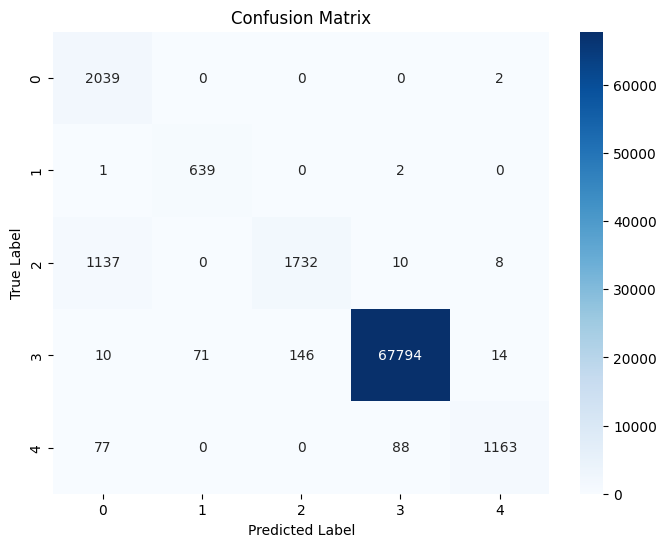

In [14]:
# prompt: plot the confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Ensure the confusion matrix 'cm' is available from the preceding code
# and that the true labels 'y_true' and predicted labels 'y_pred' are also available.

# Get the unique class labels from the true labels.
labels = np.unique(y_true)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


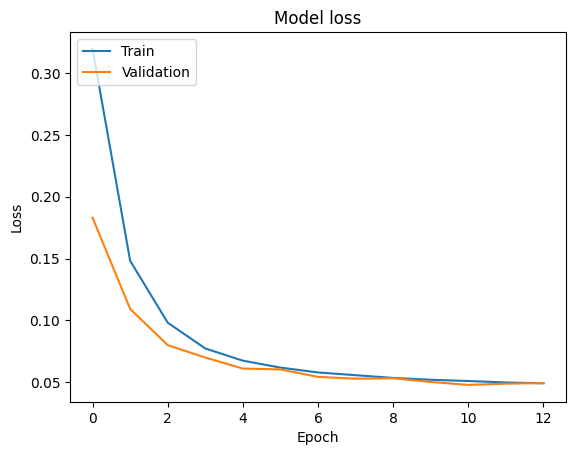

In [15]:
# prompt: plot a digram of validation loss and  training loss with epochs

import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


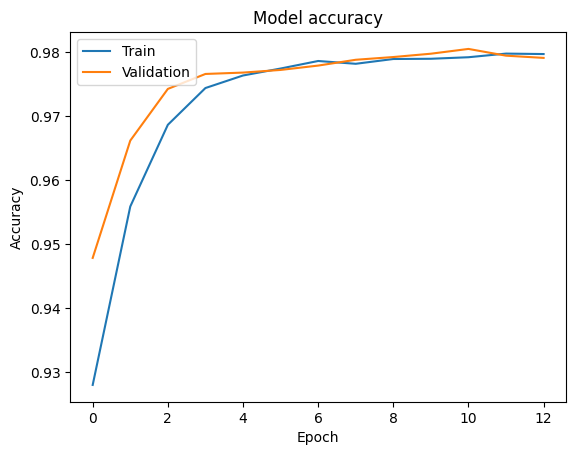

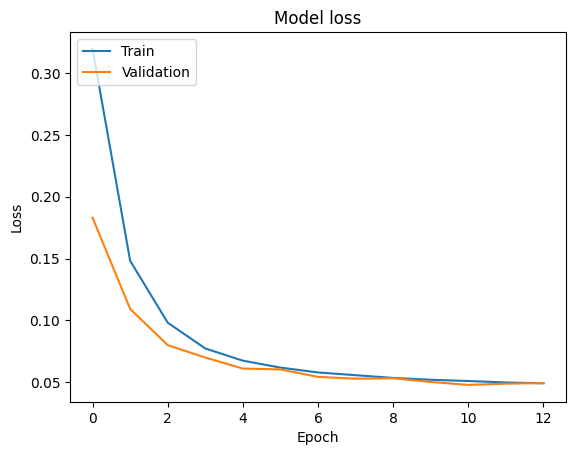

In [16]:
# prompt: plot the the accuracy and loss

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
# prompt: claculate  Precision ,
# Recall ,
# F1-score

from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Ensure the predicted labels 'y_pred' and true labels 'y_true' are available
# from the preceding code.

# Calculate Precision
precision = precision_score(y_true, y_pred, average='weighted') # Use 'weighted' for multiclass classification
print(f"Precision: {precision:.4f}")

# Calculate Recall
recall = recall_score(y_true, y_pred, average='weighted') # Use 'weighted' for multiclass classification
print(f"Recall: {recall:.4f}")

# Calculate F1-score
f1 = f1_score(y_true, y_pred, average='weighted') # Use 'weighted' for multiclass classification
print(f"F1-score: {f1:.4f}")


Precision: 0.9842
Recall: 0.9791
F1-score: 0.9791


In [ ]:
'''# Define input layer
inputs = Input(shape=(11, 1))

# Hidden layers
x = Dense(100, activation='relu')(inputs)
x = LSTM(256, recurrent_dropout=0.23, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
outputs = Dense(5, activation='softmax')(x)

# Create model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, mode='auto', verbose=0)

checkpoint_path = 'model.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   mode='auto',
                                   verbose=1)
